# M115 - Image Analysis and Processing, Assignment 2 (Notebook 2)

This is the second part of Assignment 2 concerning the creation of an intelligent system to detect pneumonia in chest X-ray images, utilising a dataset available at [Kaggle Chest X-Ray Images (Pneumonia) dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia).

Here, a Convolutional Neural Netwrok is developed for that purpose. For the classical ML approach, please refer to [Notebook 1](https://github.com/mdarm/Pneumonia-X-Ray-Detection/blob/main/src/classical-ml.ipynb).

---

Please note that this notebook was executed on a Kaggle machine equipped with 16GB of RAM, 2 CPUs and a Tesla P100-PCIE-16GB GPU. If you are rerunning this notebook locally or on a different platform such as Google Colab, you may encounter issues due to differences in the computing environment.

Before running any other code, it is crucial to execute the first four code cells to import all necessary libraries. Failing to do so may result in matplotlib not functioning correctly.

Lastly, run all cells in the order they appear. Many parts of the analysis depend on results or instances created in previous cells.

---

# Table of Contents
* [Utilise Available Resources](#scrollTo=resources)
* [Balance Dataset](#scrollTo=balance)
* [Data Pre-processing & Augmentation](#scrollTo=augmentation)
* [CNN Architecture](#scrollTo=cnn)
  1. [Model fitting](#scrollTo=fit)
  2. [Model evaluation](#scrollTo=evaluate)
  3. [Running the model and statistical significance](#scrollTo=ss)
* [Results and Comparison with Classical ML](#scrollTo=results)
  1. [Deep learning potential improvements](#scrollTo=improve)

In [1]:
# Dependencies for rendering text of matplotlib in LaTeX
!sudo apt update -y
!sudo apt install -y cm-super dvipng texlive-latex-extra texlive-latex-recommended

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [416 kB]
Get:3 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5002 B]
Get:4 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:7 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Get:8 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [482 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [725 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [749 kB]
Get:13 http://security.ubuntu.com/u

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import time
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint

# Consider aesthetics and consistency
plt.rcParams.update({
        "text.usetex": True,
        "font.size": 15,
        'mathtext.default': 'regular',
        'axes.titlesize': 16,
        "axes.labelsize": 16,
        "legend.fontsize": 15,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
        'figure.titlesize': 16,
        'figure.figsize': (12, 7),
        'text.latex.preamble': r'\usepackage{amsmath,amssymb}',
        "font.family": "serif",
        "font.serif": "computer modern roman",
        })

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<a id="scrollTo=resources"></a>
## Utilise available resources

Starting off, check the available resources.

In [3]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Get number of CPU cores
num_cpu_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cpu_cores}")

# Get GPU name
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU name: {gpu_name}")
else:
    print("No GPU available")

Device: cuda
Number of CPU cores: 2
GPU name: Tesla P100-PCIE-16GB


Kaggle's Tesla P100 will be used for training and evaluating the neural model. Also 2 workers (2 CPUs) will be employed for the loading and batching of the data.

<a id="scrollTo=balance"></a>
## Balance Dataset

As was observed in [Notebook 1](https://github.com/mdarm/Pneumonia-X-Ray-Detection/blob/main/src/classical-ml.ipynb), there is a class imbalance, with more pneumonia images than normal images. This can lead to a biased model that may not perform well on the under-represented class. To address this issue, the dataset will be balanced by applying oversampling, undersampling, or a combination of both to make the number of samples in each class equal. This can potentially help the CNN's performance on the under-represented class.

In [4]:
def create_weighted_sampler(h, dataset):
    targets = [label for _, label in dataset]
    class_counts = np.bincount(targets)
    class_weights = 1.0 / class_counts
    weights = [class_weights[label] for label in targets]
    sampler = WeightedRandomSampler(weights, len(weights))
    return sampler

<a id="scrollTo=augmentation"></a>
## Data Pre-processing & Augmentation

As opposed to Notebook 1, the preprocessing here will be significantly different given than a CNN will be used.

The images' center will now be cropped, as opposed to resizing them, which could potentially distort their aspect ratio. The original proportions of the image are preserved by this alteration, aiding the CNN in better learning from the dataset and comprehending the inherent characteristics of the images.

Data augmentation techniques will also be leveraged to enhance the diversity of the training dataset. New training examples are generated through subtle alterations to the original images, such as rotation, flipping, and translation. Overfitting is effectively prevented by this strategy, enabling the CNN to become more resilient and proficient in generalising unseen data.

To correctly implement these techniques, a separate transformation for the training data has been designed, ensuring the test set remains unaffected by these augmentations. The same cautious approach is taken with the validation set, maintaining its authenticity by ensuring it does not undergo any data augmentation.

Normalisation will still be performed on the whole dataset of course.

Here's a brief overview of the aforementioned pipeline:

<div style="text-align:center">
<img src="https://i.imgur.com/aTDU4Vt.png" alt="workflow3" width="500" height="600"/>
</div>

With the augmented volume of data, the CNN can be trained in more epochs without the risk of overfitting. This presents an opportunity to further refine the CNN's learning through additional training iterations, which should result in more accurate predictions.

With these enhancements and considerations in place, and enhanced ability of the CNN to perform better on unseen data while maintaining robustness against overfitting can reasonably be expected.

In [5]:
def prepare_data(h):
    data_transforms = transforms.Compose([
        transforms.Resize(size=(h["image_size"], h["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    data_transforms_train = transforms.Compose([
        transforms.RandomRotation(20),                                               # Randomly rotate image
        transforms.RandomHorizontalFlip(p=0.5),                                      # Randomly flip image
        transforms.ColorJitter(brightness=0.1, contrast=0.1,
                               saturation=0.1, hue=0.1),                             # Randomly change the b/c/h
        transforms.RandomApply([transforms.RandomAffine(0, 
                               translate=(0.1, 0.1))], p=0.5),                       # Randomly apply affine transformations with translation
        transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)],
                               p=0.5),                                               # Randomly apply perspective transformations
        transforms.Resize(size=(h["image_size"], h["image_size"])),                  # Resize data
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],                             # Normalise data
                            std=[0.229, 0.224, 0.225])
    ])


    # Define the validation split percentage
    val_split = 0.2

    # Load the datasets
    train_dataset = datasets.ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/train/",
                                         transform=data_transforms_train)
    val_dataset = datasets.ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/train/",
                                       transform=data_transforms)    
    test_dataset = datasets.ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/test/",
                                        transform=data_transforms)

    # Create the data loaders for train, validation, and test sets
    if (h["balance"]):
        sampler = create_weighted_sampler(h, train_dataset)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=h["batch_size"],
                                                   sampler=sampler, num_workers=2)    
    else:
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=h["batch_size"],
                                                   shuffle=True, num_workers=2)    
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=h["batch_size"],
                                             shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=h["batch_size"],
                                              shuffle=True, num_workers=2)

    return train_loader, val_loader, test_loader

<a id="scrollTo=cnn"></a>
## CNN Architecture

As mentioned before, the model of choice will be a Convolutional Neural Network. CNNs are designed to work with image data and can capture local patterns more efficiently than fully connected layers. They can also handle larger input images, which can lead to better performance.

The custom CNN architecture will consist of multiple convolutional layers, followed by max-pooling layers, and finally a fully connected layer for classification. The image size will be set to 256x256, as CNNs can handle larger images better.

Here's a brief overview of the CNN's architecture:

<div style="text-align:center">
<img src="https://i.imgur.com/TcvLftf.png" alt="cnn" width="500" height="600"/>
</div>

In [6]:
def create_model(h, device):
    if (h["model"]=="cnn"):
        model = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(64 * (h["image_size"] // 8) * (h["image_size"] // 8), 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, 2)
        )
        model = model.to(device)
        return model

<a id="scrollTo=fit"></a>
### Model fitting

Provided the augmentation of the dataset, the model will be trained for 10 epochs, using a 0.001 learning rate.

In [7]:
h = {
    "balance": True,
    "num_epochs": 10,
    "batch_size": 256,
    "image_size": 256,
    "lr": 0.001,
    "model": "cnn"
}


def train_model(h, model, train_loader, val_loader, optimizer, criterion, device):
    train_loss_history = []
    val_loss_history = []

    start_time = time.time()
    num_epochs = h["num_epochs"]

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{num_epochs}", leave=False, unit="mini-batch")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)      
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())


        val_loss, _, _, _ = evaluate_model(h, model, val_loader, criterion, device)
        
        # Store the loss history
        train_loss = running_loss / len(train_loader)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)

        # Calculate elapsed time and remaining time
        elapsed_time = time.time() - start_time
        avg_time_per_epoch = elapsed_time / (epoch + 1)
        remaining_epochs = num_epochs - (epoch + 1)
        remaining_time = avg_time_per_epoch * remaining_epochs

        # Convert remaining time to minutes and seconds
        remaining_time_min, remaining_time_sec = divmod(remaining_time, 60)

        print(f"Epoch [{epoch + 1}/{num_epochs}]: Train Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Remaining Time: {remaining_time_min:.0f}m {remaining_time_sec:.0f}s")

    return train_loss_history, val_loss_history

<a id="scrollTo=evaluation"></a>
### Model evaluation

The F1 score will be used as a basic evaluation metric. It is useful for evaluating models when there is class imbalance, as it provides a more balanced measure of the model's performance. The F1 score ranges from 0 (worst) to 1 (best).

In [8]:
def plot_confusion_matrix(predictions, y_test, title):
    labels = ['Normal', 'Pnuemonia']
    
    cm = confusion_matrix(y_test,predictions)
    cm = pd.DataFrame(cm , index = labels , columns = labels)
    
    plt.figure()
    sns.heatmap(cm, cmap="YlGnBu", linecolor = 'black' , linewidth = 1,
                annot = True, fmt='', xticklabels = labels,
                yticklabels = labels)
    
    plt.title(title, fontsize = 20)
    plt.xlabel('Predicted', fontsize = 15)
    plt.ylabel('Actual', fontsize = 15)
    
    plt.savefig('/kaggle/working/confusionMatrix.pdf',
                format='pdf', bbox_inches='tight', dpi=300, transparent=True)
    plt.show()
    

def evaluate_model(h, model, data_loader, criterion, device):
    true_labels = []
    predicted_labels = []
    total_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)          

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    epoch_loss = total_loss / len(data_loader)
    epoch_accuracy = correct / total

    return epoch_loss, epoch_accuracy, true_labels, predicted_labels


def plot_metrics(h, train_loss_history, val_loss_history, test_loss, test_accuracy, true_labels, predicted_labels):
    print(f"Accuracy on the test set: {test_accuracy:.2%}")

    # Calculate precision, recall, and F1 score using the accumulated true labels and predictions
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")

    # Calculate the confusion matrix using the accumulated true labels and predictions
    plot_confusion_matrix(predicted_labels, true_labels,
                          'CNN with Data Augmentation and class weighting')

    # Plot the learning curves
    plt.figure()
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss history')
    plt.legend()
    plt.savefig('/kaggle/working/LossHistory.pdf',
                format='pdf', bbox_inches='tight', dpi=300, transparent=True)
    
    plt.show()  

<a id="scrollTo=ss"></a>
### Running the model and Statistical Significance

Since the training process is random, the training and testing will be repeated several times to measure the statistical significance of the results.

Hyperparameters:
{'balance': True,
 'batch_size': 256,
 'image_size': 256,
 'lr': 0.001,
 'model': 'cnn',
 'num_epochs': 10}
Running solution 1/5


Epoch [1/10]: Train Loss: 0.7957, Val Loss: 0.6526, Remaining Time: 87m 27s


Epoch [2/10]: Train Loss: 0.3997, Val Loss: 0.2494, Remaining Time: 77m 28s


Epoch [3/10]: Train Loss: 0.2588, Val Loss: 0.2174, Remaining Time: 67m 38s


Epoch [4/10]: Train Loss: 0.2187, Val Loss: 0.1533, Remaining Time: 58m 1s


Epoch [5/10]: Train Loss: 0.1845, Val Loss: 0.1877, Remaining Time: 48m 20s


Epoch [6/10]: Train Loss: 0.1755, Val Loss: 0.2248, Remaining Time: 38m 41s


Epoch [7/10]: Train Loss: 0.1895, Val Loss: 0.1495, Remaining Time: 29m 0s


Epoch [8/10]: Train Loss: 0.1604, Val Loss: 0.3257, Remaining Time: 19m 21s


Epoch [9/10]: Train Loss: 0.1754, Val Loss: 0.1356, Remaining Time: 9m 41s


Epoch [10/10]: Train Loss: 0.1422, Val Loss: 0.1176, Remaining Time: 0m 0s
Accuracy on the test set: 82.37%
Precision: 0.80, Recall: 0.96, F1 score: 0.87


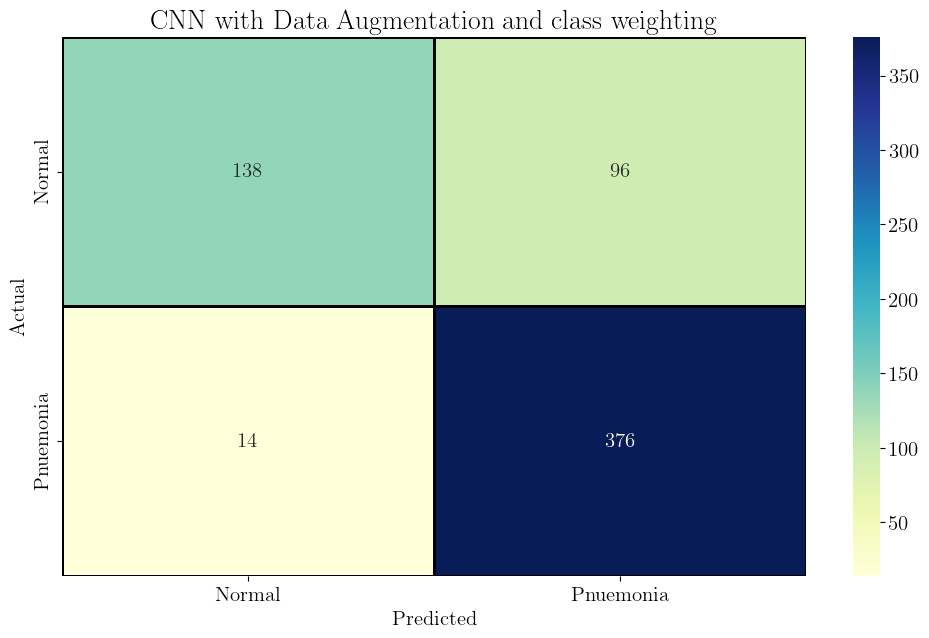

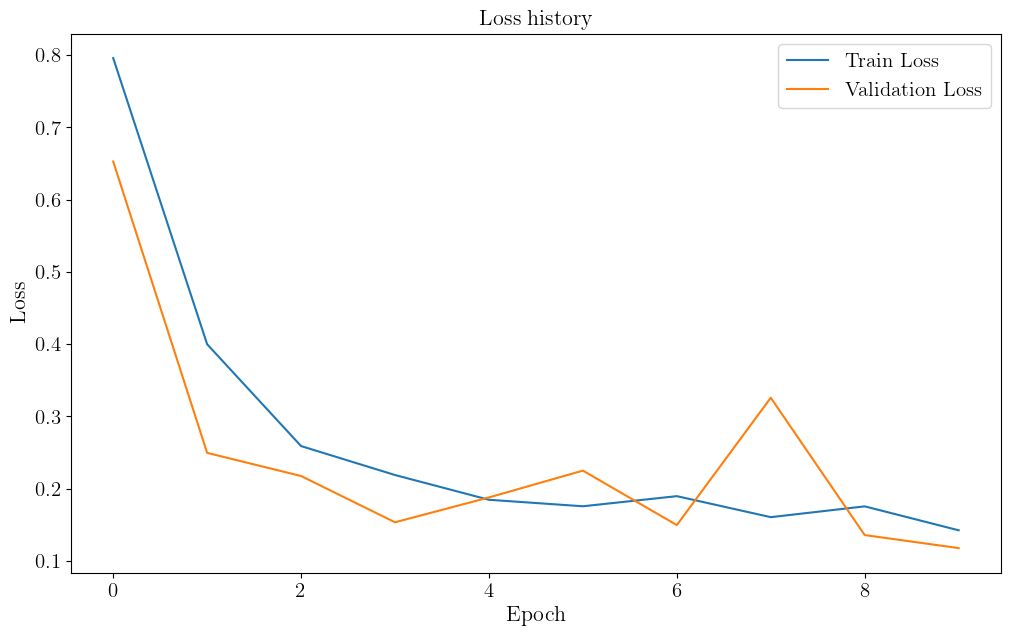

F1 = 0.87, accuracy = 0.82 
Running solution 2/5


Epoch [1/10]: Train Loss: 1.2731, Val Loss: 0.6837, Remaining Time: 88m 3s


Epoch [2/10]: Train Loss: 0.4579, Val Loss: 0.3153, Remaining Time: 77m 49s


Epoch [3/10]: Train Loss: 0.3315, Val Loss: 0.1912, Remaining Time: 68m 10s


Epoch [4/10]: Train Loss: 0.2595, Val Loss: 0.1946, Remaining Time: 57m 56s


Epoch [5/10]: Train Loss: 0.2017, Val Loss: 0.1450, Remaining Time: 48m 16s


Epoch [6/10]: Train Loss: 0.1932, Val Loss: 0.2256, Remaining Time: 38m 33s


Epoch [7/10]: Train Loss: 0.2145, Val Loss: 0.1503, Remaining Time: 28m 58s


Epoch [8/10]: Train Loss: 0.1975, Val Loss: 0.2401, Remaining Time: 19m 18s


Epoch [9/10]: Train Loss: 0.1886, Val Loss: 0.1765, Remaining Time: 9m 39s


Epoch [10/10]: Train Loss: 0.1729, Val Loss: 0.1803, Remaining Time: 0m 0s
F1 = 0.91, accuracy = 0.88 
Running solution 3/5


Epoch [1/10]: Train Loss: 1.0000, Val Loss: 0.5594, Remaining Time: 87m 37s


Epoch [2/10]: Train Loss: 0.4026, Val Loss: 0.1874, Remaining Time: 76m 55s


Epoch [3/10]: Train Loss: 0.2952, Val Loss: 0.1682, Remaining Time: 67m 24s


Epoch [4/10]: Train Loss: 0.2331, Val Loss: 0.2374, Remaining Time: 58m 4s


Epoch [5/10]: Train Loss: 0.2583, Val Loss: 0.1589, Remaining Time: 48m 34s


Epoch [6/10]: Train Loss: 0.2167, Val Loss: 0.2128, Remaining Time: 38m 51s


Epoch [7/10]: Train Loss: 0.1875, Val Loss: 0.1610, Remaining Time: 29m 7s


Epoch [8/10]: Train Loss: 0.1814, Val Loss: 0.1320, Remaining Time: 19m 26s


Epoch [9/10]: Train Loss: 0.1973, Val Loss: 0.1213, Remaining Time: 9m 43s


Epoch [10/10]: Train Loss: 0.1784, Val Loss: 0.1716, Remaining Time: 0m 0s
F1 = 0.90, accuracy = 0.87 
Running solution 4/5


Epoch [1/10]: Train Loss: 1.0857, Val Loss: 0.7062, Remaining Time: 90m 41s


Epoch [2/10]: Train Loss: 0.5054, Val Loss: 0.9472, Remaining Time: 80m 18s


Epoch [3/10]: Train Loss: 0.3196, Val Loss: 0.4076, Remaining Time: 70m 54s


Epoch [4/10]: Train Loss: 0.2683, Val Loss: 0.2110, Remaining Time: 60m 47s


Epoch [5/10]: Train Loss: 0.2412, Val Loss: 0.1971, Remaining Time: 50m 25s


Epoch [6/10]: Train Loss: 0.2096, Val Loss: 0.1940, Remaining Time: 40m 21s


Epoch [7/10]: Train Loss: 0.1876, Val Loss: 0.1660, Remaining Time: 30m 12s


Epoch [8/10]: Train Loss: 0.1914, Val Loss: 0.1453, Remaining Time: 20m 4s


Epoch [9/10]: Train Loss: 0.1770, Val Loss: 0.1264, Remaining Time: 10m 1s


Epoch [10/10]: Train Loss: 0.1812, Val Loss: 0.1126, Remaining Time: 0m 0s
F1 = 0.84, accuracy = 0.76 
Running solution 5/5


Epoch [1/10]: Train Loss: 1.0947, Val Loss: 0.6868, Remaining Time: 88m 14s


Epoch [2/10]: Train Loss: 0.3975, Val Loss: 0.1828, Remaining Time: 79m 18s


Epoch [3/10]: Train Loss: 0.2612, Val Loss: 0.2158, Remaining Time: 69m 35s


Epoch [4/10]: Train Loss: 0.2095, Val Loss: 0.1616, Remaining Time: 59m 52s


Epoch [5/10]: Train Loss: 0.1882, Val Loss: 0.2210, Remaining Time: 49m 49s


Epoch [6/10]: Train Loss: 0.2015, Val Loss: 0.1629, Remaining Time: 39m 52s


Epoch [7/10]: Train Loss: 0.1664, Val Loss: 0.1442, Remaining Time: 29m 54s


Epoch [8/10]: Train Loss: 0.1457, Val Loss: 0.2649, Remaining Time: 19m 58s


Epoch [9/10]: Train Loss: 0.1572, Val Loss: 0.1174, Remaining Time: 9m 58s


Epoch [10/10]: Train Loss: 0.1479, Val Loss: 0.2661, Remaining Time: 0m 0s
F1 = 0.90, accuracy = 0.88 
Results
F1 List: [0.87238979 0.90598291 0.89890378 0.8380744  0.89986996]
Accuracy List: [0.82371795 0.87660256 0.86698718 0.76282051 0.87660256]
F1: 88.3% (+-2.5%)
Accuracy: 84.1% (+-4.4%)
Time of one solution: 106m 46s
 | 88.3% (+-2.5%) | 84.1% (+-4.4%) | 106m 46s


In [9]:
def check_solution(h, device, verbose):
    train_loader, val_loader, test_loader = prepare_data(h)
    model = create_model(h, device)
    optimizer = torch.optim.Adam(model.parameters(), lr=h["lr"])
    criterion = nn.CrossEntropyLoss()
    train_loss_history, val_loss_history = train_model(h, model, train_loader,
                                                       val_loader, optimizer, criterion, device)
    test_loss, test_accuracy, true_labels, predicted_labels = evaluate_model(h, model, test_loader,
                                                                             criterion, device)
    if verbose:
        plot_metrics(h, train_loss_history, val_loss_history, test_loss, test_accuracy,
                     true_labels, predicted_labels)

    f1 = f1_score(true_labels, predicted_labels)

    return f1, test_accuracy


# Print hyperparameters for records
print("Hyperparameters:")
pprint.pprint(h)

f1_array = np.array([])
accuracy_array = np.array([])
start_time = time.time()

repeats = 5
for i in range(repeats):
    print(f"Running solution {i+1}/{repeats}")
    f1, accuracy = check_solution(h, device, verbose=(i==0))
    print(f"F1 = {f1:.2f}, accuracy = {accuracy:.2f} ")
    f1_array = np.append(f1_array, f1)
    accuracy_array = np.append(accuracy_array, accuracy) 

# Calculate elapsed time and remaining time
repeat_time = (time.time() - start_time) / repeats
repeat_time_min, repeat_time_sec = divmod(repeat_time, 60)

# Printing final results
print("Results")
print(f"F1 List: {f1_array}")
print(f"Accuracy List: {accuracy_array}")
print(f"F1: {np.mean(f1_array):.1%} (+-{np.std(f1_array):.1%})")
print(f"Accuracy: {np.mean(accuracy_array):.1%} (+-{np.std(accuracy_array):.1%})")
print(f"Time of one solution: {repeat_time_min:.0f}m {repeat_time_sec:.0f}s")

print(f" | {np.mean(f1_array):.1%} (+-{np.std(f1_array):.1%}) | {np.mean(accuracy_array):.1%} (+-{np.std(accuracy_array):.1%}) | {repeat_time_min:.0f}m {repeat_time_sec:.0f}s")

<a id="scrollTo=results"></a>
## Results and comparison with Classical ML

The performance of the Convolutional Neural Neural (CNN) model in comparison to the best classical machine learning model, Logistic Regression, showed a relatively comparable outcome. The 89% f1 scole of the logistic regression, is within the averaged 88.4% (+-1.1%) f1 score of the CNN. The uncertainty is for a confidence interval of one standard deviation

The CNN model yielded **three fewer false positives** but, interestingly, also had **six more false negatives**. One key advantage of the CNN over Logistic Regression lies in its immense flexibility. The CNN is highly customizable, with a myriad of optimizations available, which could potentially render it as a more scalable option in the future.

Nevertheless, one must consider the fact that Logistic Regression requires considerably less time for its processing, and its simplicity, especially with respect to feature extraction, cannot be overlooked. It is essential to bear in mind these aspects when evaluating the overall performance and potential applicability of both models.

<a id="scrollTo=improve"></a>
### Deep learning potential improvements

Potential CNN improvements could include the introduction of a Learning rate scheduler and early stopping with model checkpointing.

Also leveraging a pretrained models such as [ResNet34](http://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html) could be of help. This technique, also known as transfer learning, uses a pre-trained model, which has already learned features from a large dataset to solve a similar problem. This could potentially help the NN achieve better performance and reduce training time, as the model has already learned useful features from the large dataset.